Goals:

Biopython: For calculating GC content, k-mer frequencies, ORFs, and more.


RepeatMasker: To find tandem or interspersed repeats.


HMMER/MEME Suite: For motif and pattern searches.


FASTA Tools: Command-line tools for sequence manipulation and statistics.


Features to target

GC/AT content


K-mer frequencies


Sequence length


Nucleotide skew


ORFs (if it's a coding sequence)


Palindromic sequences


Shannon entropy
Repeats and motifs (with computational tools)

In [1]:
!pip install biopython
!pip install SeqIO

# 환경 다시 만들고 돌려보기

#fasta parser

In [2]:
# # Unzip the file into a folder named 'dataset'
# !unzip -q dataset.zip -d dataset

# # Verify the contents of the 'dataset' folder
# print("Contents extracted to 'dataset':")
# !ls dataset


In [1]:
import os
from Bio import SeqIO
import pandas as pd

# Directory containing the dataset
base_dir = "dataset"

# Function to parse a single .fna file and extract sequence
def parse_fna(file_path):
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

def get_header_as_list(file_path):
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith(">"):  # Check if the line is a header
                return line.strip().split(" ")  # Strip newline and split by space
    return []

# Process all files in the dataset directory
data = []

for root, dirs, files in os.walk(base_dir):
    for file_name in files:
        if file_name.startswith(("axolotl")) and file_name.endswith(".fna"):  # add "zebrafish" to include or jsut use axolotl
            # Determine folder name (e.g., 'regen' or 'non-regen')
            folder_name = os.path.basename(root)
            regen_value = 1 if folder_name.lower() == "regen" else 0  # regen: 1, non-regen: 0

            # Parse file
            gene_name = file_name.replace("axolotl_", "").replace("zebrafish_", "").replace("_.fna", "")
            file_path = os.path.join(root, file_name)
            sequences = parse_fna(file_path)

            first_line = get_header_as_list(file_path)

            organism = first_line[2].split("=")[1] + " " + first_line[3].strip("]")
            gene_id = first_line[4].split("=")[1].strip("]")
            chromosome = first_line[5].split("=")[1].strip("]")

            for seq in sequences:
                data.append({"gene_name": gene_name, "sequence": seq, "organism": organism, "gene_id": gene_id, "chromosome": chromosome, "regen": regen_value})

# Convert to DataFrame
df = pd.DataFrame(data)
print(f"Processed {len(df)} sequences.")
print(df.head())

# Save as a CSV for feature engineering
df.to_csv("processed_genes.csv", index=False)


Processed 81 sequences.
  gene_name                                           sequence  \
0    THAP11  TGTCACCGGAAGCTGTTAGCATTGTGGGACATGTAGTTCCGGTTCG...   
1      EPS8  AGTGCAGAGCCGCGCGCGCGCTAGCTAACGCAGTCCGGCGCCAGCT...   
2    CTNNB1  AGGGAGGAGCCATACATCCTCTACCTGAATCTCAGCCCTGACCCAG...   
3   ARHGDIA  TTTCTAGAGCTCTCTTGTGGGACGGGAACTAGATAGACCGGAACTA...   
4      ATP6  ATGAACCTAAGCTTTTTTGACCAATTCATAAGCCCAACTATGTTAG...   

              organism    gene_id chromosome  regen  
0  Ambystoma mexicanum  138583276         1p      0  
1  Ambystoma mexicanum  138513481         12      0  
2  Ambystoma mexicanum  138569875         2q      0  
3  Ambystoma mexicanum  138583232         3q      0  
4  Ambystoma mexicanum    2763194         MT      0  


In [2]:
df.tail(5)

,gene_name,sequence,organism,gene_id,chromosome,regen
76,TWIST1,AGACCCACCTCGGCGGCTGTGCGTGTGTCCCAGGAGCTGGCTGCCA...,Ambystoma mexicanum,138569986,2q,1
77,SHOX,ATTGAGAAGCATAAATAAGTGCAGGAGTGATCGAAGCCCGGCGCAG...,Ambystoma mexicanum,138526201,7p,1
78,HOXD8,TTGTACAGAAAAAGTCCATGGCATTGCAAAGTAGCGTTGCGATGAA...,Ambystoma mexicanum,138488813,9,1
79,HMOX1,ACGCGAGGAGCACAGAGGCGCAGCTGTGCAGGACGCGCGACGAGGA...,Ambystoma mexicanum,138582764,3q,1
80,P53,CATTTTAGTTCTTCGTCAGGACAGCCAACTTGCAGGACCCGTATTG...,Ambystoma mexicanum,138567300,1p,1


In [2]:
import pandas as pd
from collections import Counter

# Function to compute k-mer frequencies
def compute_kmer_frequencies(sequence, k=3):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    kmer_counts = Counter(kmers)
    total_kmers = sum(kmer_counts.values())
    # Normalize counts
    kmer_frequencies = {f"kmer_{k}_{key}": val / total_kmers for key, val in kmer_counts.items()}
    return kmer_frequencies

# Function to compute GC content
def compute_gc_content(sequence):
    gc_count = sequence.count("G") + sequence.count("C")
    return gc_count / len(sequence) if len(sequence) > 0 else 0

# Function to compute AT/GC ratio
def compute_at_gc_ratio(sequence):
    at_count = sequence.count("A") + sequence.count("T")
    gc_count = sequence.count("G") + sequence.count("C")
    return at_count / gc_count if gc_count > 0 else 0

# Generate features for each sequence
features = []
for _, row in df.iterrows():
    sequence = row['sequence']
    feature_row = {
        "gene_name": row['gene_name'],
        "sequence_length": len(sequence),
        "gc_content": compute_gc_content(sequence),
        "at_gc_ratio": compute_at_gc_ratio(sequence),
    }
    # Add k-mer frequencies (e.g., k=3)
    feature_row.update(compute_kmer_frequencies(sequence, k=3))
    features.append(feature_row)

# Convert features to DataFrame
features_df = pd.DataFrame(features)

# Fill missing k-mers with zeros
features_df.fillna(0, inplace=True)

print(features_df.head())

# Save features to CSV for modeling
features_df.to_csv("gene_features.csv", index=False)


  gene_name  sequence_length  gc_content  at_gc_ratio  kmer_3_TGT  kmer_3_GTC  \
0    THAP11             4237    0.447014     1.237064    0.025502    0.009445   
1      EPS8          1868600    0.452794     1.208509    0.021140    0.011779   
2    CTNNB1            97743    0.465343     1.148953    0.020800    0.011428   
3   ARHGDIA            89866    0.470211     1.126704    0.020965    0.012497   
4      ATP6              684    0.327485     2.053571    0.008798    0.005865   

   kmer_3_TCA  kmer_3_CAC  kmer_3_ACC  kmer_3_CCG  ...  kmer_3_AAT  \
0    0.013459    0.015821    0.012515    0.011570  ...    0.022196   
1    0.017392    0.015652    0.013585    0.006356  ...    0.019608   
2    0.015643    0.015654    0.014242    0.005504  ...    0.018099   
3    0.016258    0.016837    0.015546    0.007267  ...    0.017415   
4    0.014663    0.010264    0.020528    0.002933  ...    0.030792   

   kmer_3_ACG  kmer_3_GAT  kmer_3_ATC  kmer_3_TGA  kmer_3_CAN  kmer_3_ANN  \
0    0.007320  

In [4]:
features_df

,gene_name,sequence_length,gc_content,at_gc_ratio,kmer_3_TGT,kmer_3_GTC,kmer_3_TCA,kmer_3_CAC,kmer_3_ACC,kmer_3_CCG,...,kmer_3_AAT,kmer_3_ACG,kmer_3_GAT,kmer_3_ATC,kmer_3_TGA,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA
0,THAP11,4237,0.447014,1.237064,0.025502,0.009445,0.013459,0.015821,0.012515,0.011570,...,0.022196,0.007320,0.013223,0.009917,0.015821,0.0,0.0,0.0,0.0,0.0
1,EPS8,1868600,0.452794,1.208509,0.021140,0.011779,0.017392,0.015652,0.013585,0.006356,...,0.019608,0.005954,0.014183,0.013613,0.018125,0.0,0.0,0.0,0.0,0.0
2,CTNNB1,97743,0.465343,1.148953,0.020800,0.011428,0.015643,0.015654,0.014242,0.005504,...,0.018099,0.005709,0.013546,0.012748,0.016400,0.0,0.0,0.0,0.0,0.0
3,ARHGDIA,89866,0.470211,1.126704,0.020965,0.012497,0.016258,0.016837,0.015546,0.007267,...,0.017415,0.006321,0.012652,0.013665,0.016837,0.0,0.0,0.0,0.0,0.0
4,ATP6,684,0.327485,2.053571,0.008798,0.005865,0.014663,0.010264,0.020528,0.002933,...,0.030792,0.001466,0.010264,0.010264,0.016129,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,TWIST1,4584,0.541012,0.848387,0.017023,0.011349,0.011567,0.028808,0.017896,0.016150,...,0.010694,0.013095,0.007420,0.008293,0.010694,0.0,0.0,0.0,0.0,0.0
77,SHOX,67715,0.456531,1.190432,0.023452,0.009939,0.017663,0.021148,0.013144,0.008049,...,0.020424,0.007177,0.012080,0.013188,0.015713,0.0,0.0,0.0,0.0,0.0
78,HOXD8,4317,0.463980,1.155267,0.019930,0.008806,0.013210,0.022480,0.013441,0.010197,...,0.019235,0.012051,0.009270,0.009502,0.014137,0.0,0.0,0.0,0.0,0.0
79,HMOX1,21586,0.469425,1.130267,0.025991,0.011258,0.015984,0.017930,0.011675,0.006069,...,0.016355,0.009081,0.011397,0.012417,0.016401,0.0,0.0,0.0,0.0,0.0


In [6]:
features_df.describe()

,sequence_length,gc_content,at_gc_ratio,kmer_3_TGT,kmer_3_GTC,kmer_3_TCA,kmer_3_CAC,kmer_3_ACC,kmer_3_CCG,kmer_3_CGG,...,kmer_3_AAT,kmer_3_ACG,kmer_3_GAT,kmer_3_ATC,kmer_3_TGA,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA
count,8.100000e+01,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,...,81.000000,81.000000,81.000000,81.000000,81.000000,8.100000e+01,8.100000e+01,81.000000,8.100000e+01,8.100000e+01
mean,2.341246e+05,0.463425,1.199737,0.020836,0.010748,0.016134,0.017717,0.014594,0.008113,0.007952,...,0.019463,0.006754,0.012218,0.012886,0.016607,1.310996e-08,1.310996e-08,0.000003,1.310996e-08,1.310996e-08
std,3.833270e+05,0.056991,0.356811,0.005030,0.002740,0.003154,0.003341,0.002572,0.003541,0.003310,...,0.009484,0.002216,0.002262,0.004029,0.003180,1.179897e-07,1.179897e-07,0.000023,1.179897e-07,1.179897e-07
min,1.680000e+02,0.255952,0.636425,0.005171,0.000000,0.006024,0.010264,0.010492,0.000000,0.000000,...,0.004536,0.000000,0.005980,0.005004,0.006780,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,5.251000e+03,0.451674,1.077516,0.019766,0.010292,0.014394,0.015855,0.013541,0.006096,0.006169,...,0.015939,0.005658,0.011397,0.011085,0.015821,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
50%,7.903200e+04,0.467849,1.136989,0.021310,0.011428,0.016700,0.017274,0.014163,0.006992,0.007044,...,0.017823,0.006301,0.012906,0.013059,0.016846,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
75%,3.386670e+05,0.481344,1.213985,0.022778,0.012225,0.017970,0.018942,0.015180,0.009155,0.009534,...,0.020113,0.007317,0.013551,0.013705,0.017627,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
max,2.309699e+06,0.611088,2.906977,0.033708,0.014173,0.026316,0.033898,0.030120,0.017978,0.018585,...,0.066265,0.013095,0.020052,0.030120,0.036145,1.061907e-06,1.061907e-06,0.000210,1.061907e-06,1.061907e-06


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop gene_name and separate features and target (assuming 'associated' as target column, update as needed)
X = features_df.drop(columns=['gene_name'])
y = (features_df['gc_content'] > 0.45).astype(int)  # Example: Binary target based on gc_content threshold

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=46)


In [8]:
X_train

array([[ 0.9959445 , -0.20746655,  0.04018176, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [-0.61203169, -2.7524154 ,  2.96654599, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [ 0.93166629, -0.18690009,  0.02412133, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       ...,
       [ 1.16854566,  0.01869181, -0.13199889, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [-0.00868494, -0.03800365, -0.08973319, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ],
       [-0.50150374,  0.56646154, -0.51213966, ..., -0.1118034 ,
        -0.1118034 , -0.1118034 ]])

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping


# Adjusting CNN-LSTM for tabular data
model = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=3,             # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=50,                 # Maximum number of epochs
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

2024-12-01 04:32:12.458252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. This error is frequently encountered on macOS when running an x86 Python installation on ARM hardware. In this case, try installing an ARM build of Python. Otherwise, you may be able work around this issue by building jaxlib from source.

In [ ]:
from graphviz import Digraph

# Create a Graphviz Digraph
dot = Digraph()

# Add nodes for each layer
dot.node('Input', 'Input Layer\n(Reshape to (seq_len, 1))')
dot.node('Conv1D', 'Conv1D Layer\n(filters=32, kernel_size=3)')
dot.node('MaxPool', 'MaxPooling1D\n(pool_size=2)')
dot.node('Dropout1', 'Dropout Layer\n(rate=0.3)')
dot.node('LSTM', 'LSTM Layer\n(units=64)')
dot.node('Dense1', 'Dense Layer\n(units=64, activation=relu)')
dot.node('Dropout2', 'Dropout Layer\n(rate=0.3)')
dot.node('Output', 'Output Layer\n(units=1, activation=sigmoid)')

# Connect nodes to represent flow
dot.edges([
    ('Input', 'Conv1D'),
    ('Conv1D', 'MaxPool'),
    ('MaxPool', 'Dropout1'),
    ('Dropout1', 'LSTM'),
    ('LSTM', 'Dense1'),
    ('Dense1', 'Dropout2'),
    ('Dropout2', 'Output')
])

# Render the diagram
dot.render('cnn_lstm_model', format='png', cleanup=True)


'cnn_lstm_model.png'

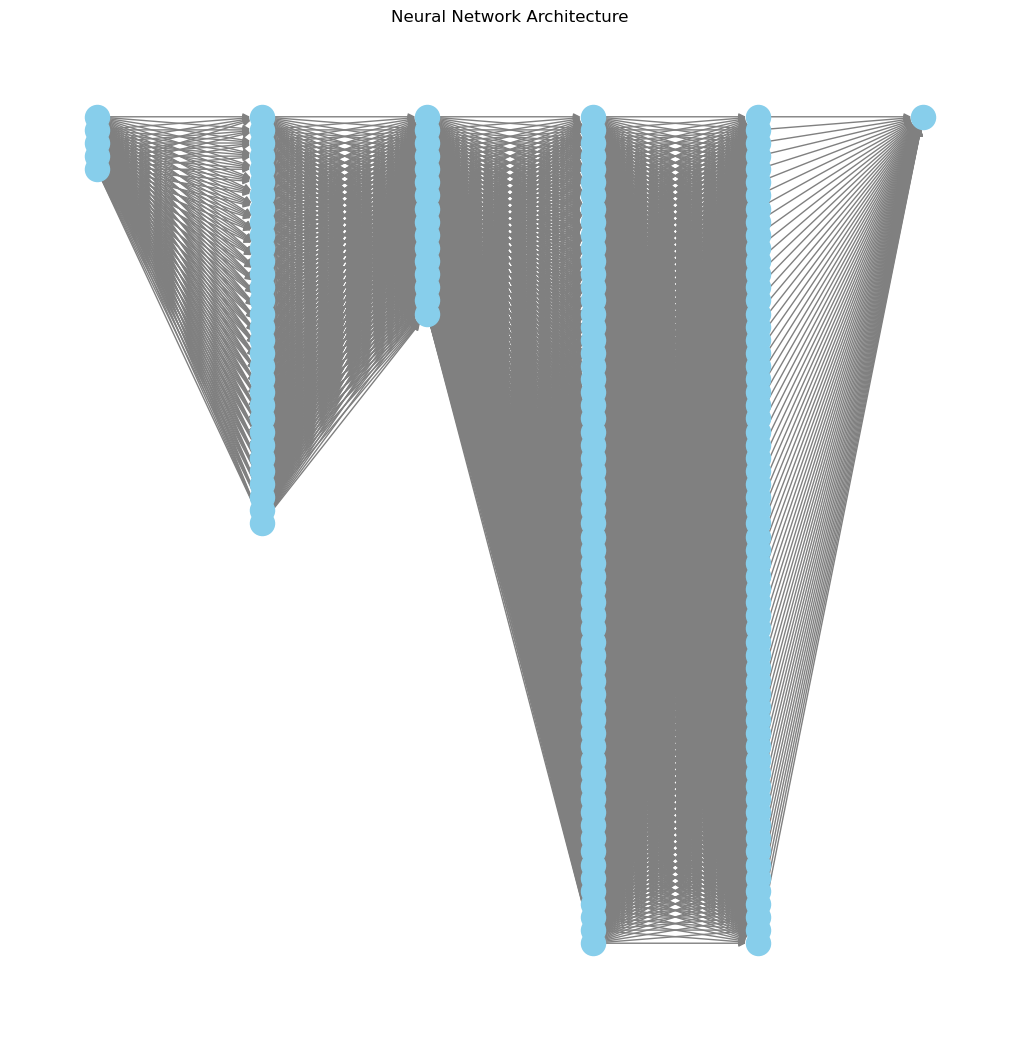

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_neural_network():
    # Initialize a directed graph
    G = nx.DiGraph()

    # Define layers and neurons
    layers = {
        "Input": 5,  # Example input size
        "Conv1D": 32,
        "MaxPool": 16,
        "LSTM": 64,
        "Dense1": 64,
        "Output": 1
    }

    # Add nodes for each layer
    prev_layer = None
    for layer, neurons in layers.items():
        for i in range(neurons):
            node = f"{layer}_{i}"
            G.add_node(node, layer=layer)
            if prev_layer:
                for prev_node in prev_layer:
                    G.add_edge(prev_node, node)
        prev_layer = [f"{layer}_{i}" for i in range(neurons)]

    # Define node positions
    pos = {}
    x_offset = 0
    for layer, neurons in layers.items():
        for i in range(neurons):
            pos[f"{layer}_{i}"] = (x_offset, -i)
        x_offset += 1

    # Draw the network
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=False, node_size=300, node_color="skyblue", edge_color="gray")
    plt.title("Neural Network Architecture")
    plt.show()

# Call the function
visualize_neural_network()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8824 - loss: 0.3362
Test Accuracy: 0.8824


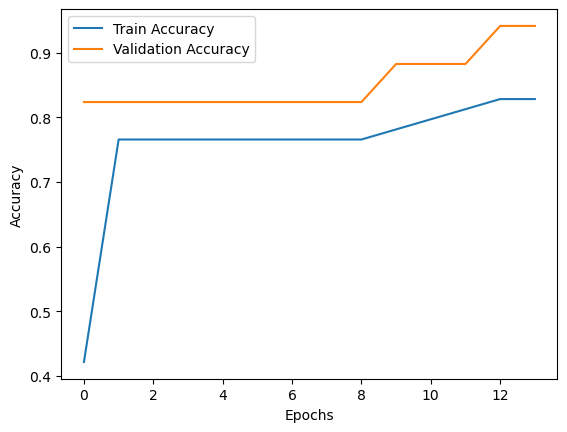

In [85]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


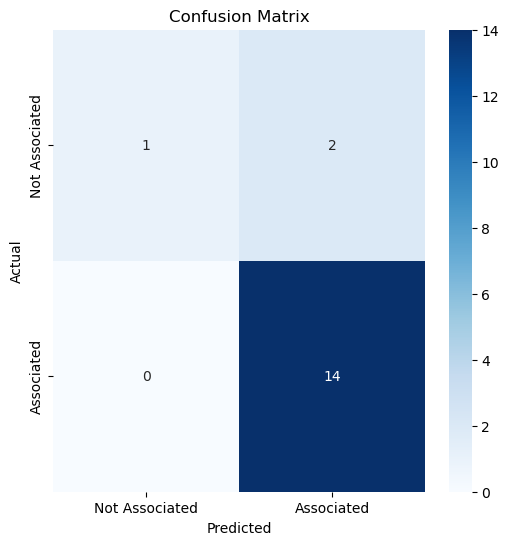

                precision    recall  f1-score   support

Not Associated       1.00      0.33      0.50         3
    Associated       0.88      1.00      0.93        14

      accuracy                           0.88        17
     macro avg       0.94      0.67      0.72        17
  weighted avg       0.90      0.88      0.86        17



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Not Associated", "Associated"]))


In [ ]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


PermutationExplainer explainer: 18it [00:37,  2.90s/it]                        


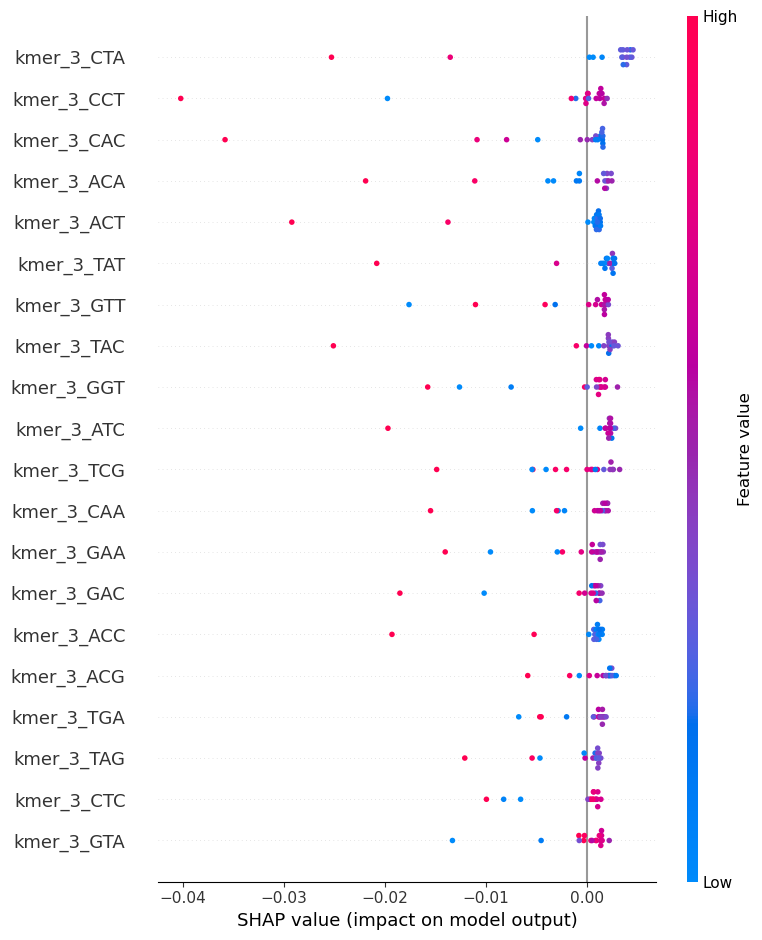


Top Influential Features:
       Feature  SHAP Importance
66  kmer_3_CTA         0.005147
65  kmer_3_CCT         0.004388
58  kmer_3_CAC         0.004345
61  kmer_3_ACA         0.003629
47  kmer_3_ACT         0.003371
55  kmer_3_TAT         0.003307
59  kmer_3_GTT         0.003280
60  kmer_3_TAC         0.003262
53  kmer_3_GGT         0.003159
62  kmer_3_ATC         0.003117


In [90]:
import shap  # To show impactful features we are using
import numpy as np
import pandas as pd

# Create SHAP explainer for your model
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Display summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Compute mean absolute SHAP values for feature importance
feature_importance = np.mean(np.abs(shap_values.values), axis=0)

# Create a DataFrame for sorting and printing
feature_names = X.columns  # Ensure X has feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': feature_importance
})

# Sort by SHAP importance
importance_df = importance_df.sort_values(by='SHAP Importance', ascending=False)

# Print the top 10 most influential features
print("\nTop Influential Features:")
print(importance_df.head(10))



In [ ]:
importance_df.head()

,Feature,SHAP Importance
66,kmer_3_CTA,0.005147
65,kmer_3_CCT,0.004388
58,kmer_3_CAC,0.004345
61,kmer_3_ACA,0.003629
47,kmer_3_ACT,0.003371


In [ ]:
# Assuming the initial DataFrame is called `importance_df` and looks similar to the provided example:

# RNA Codon Table
RNA_CODON_TABLE = {
    'UUU': 'F', 'UUC': 'F', 'UUA': 'L', 'UUG': 'L',
    'UCU': 'S', 'UCC': 'S', 'UCA': 'S', 'UCG': 'S',
    'UAU': 'Y', 'UAC': 'Y', 'UAA': '*', 'UAG': '*',
    'UGU': 'C', 'UGC': 'C', 'UGA': '*', 'UGG': 'W',
    'CUU': 'L', 'CUC': 'L', 'CUA': 'L', 'CUG': 'L',
    'CCU': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAU': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGU': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'AUU': 'I', 'AUC': 'I', 'AUA': 'I', 'AUG': 'M',
    'ACU': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAU': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGU': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GUU': 'V', 'GUC': 'V', 'GUA': 'V', 'GUG': 'V',
    'GCU': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAU': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGU': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

# Step 1: Extract DNA sequences from the `Feature` column (removing prefix)
importance_df['DNA'] = importance_df['Feature'].str.replace('kmer_3_', '')

# Step 2: Convert DNA to RNA
# Define the mapping for DNA to RNA conversion
conversion_map = str.maketrans({'A': 'U', 'T': 'A', 'C': 'G', 'G': 'C'})

# Apply the conversion to the 'DNA' column and create the 'RNA' column
importance_df['RNA'] = importance_df['DNA'].str.translate(conversion_map)


# Step 3: Translate RNA to amino acids using the RNA codon table
importance_df['Amino Acid'] = importance_df['RNA'].map(RNA_CODON_TABLE)

dna_rna_amino_acid_df = importance_df


In [101]:
dna_rna_amino_acid_df.head(5)

,Feature,SHAP Importance,DNA,RNA,Amino Acid
66,kmer_3_CTA,0.005147,CTA,CUA,L
65,kmer_3_CCT,0.004388,CCT,CCU,P
58,kmer_3_CAC,0.004345,CAC,CAC,H
61,kmer_3_ACA,0.003629,ACA,ACA,T
47,kmer_3_ACT,0.003371,ACT,ACU,T


In [ ]:
# Count occurrences of each amino acid
amino_acid_counts = dna_rna_amino_acid_df['Amino Acid'].value_counts()

# Display amino acid frequencies
print("Amino Acid Frequencies:")
print(amino_acid_counts)


Amino Acid Frequencies:
Amino Acid
L    6
S    6
R    6
T    4
V    4
G    4
P    4
A    4
I    3
*    3
F    2
C    2
K    2
E    2
N    2
D    2
Q    2
Y    2
H    2
M    1
W    1
Name: count, dtype: int64


In [105]:
# Aggregate SHAP importance by amino acid
amino_acid_shap = dna_rna_amino_acid_df.groupby('Amino Acid')['SHAP Importance'].sum()

# Combine counts and SHAP importance
amino_acid_analysis = pd.DataFrame({
    'Count': amino_acid_counts,
    'Total SHAP Importance': amino_acid_shap
}).sort_values(by='Total SHAP Importance', ascending=False)

amino_acid_analysis


,Count,Total SHAP Importance
Amino Acid,,
L,6,0.011619
T,4,0.011441
S,6,0.009070
V,4,0.006831
Y,2,0.006570
P,4,0.006093
*,3,0.004948
I,3,0.004751
H,2,0.004439


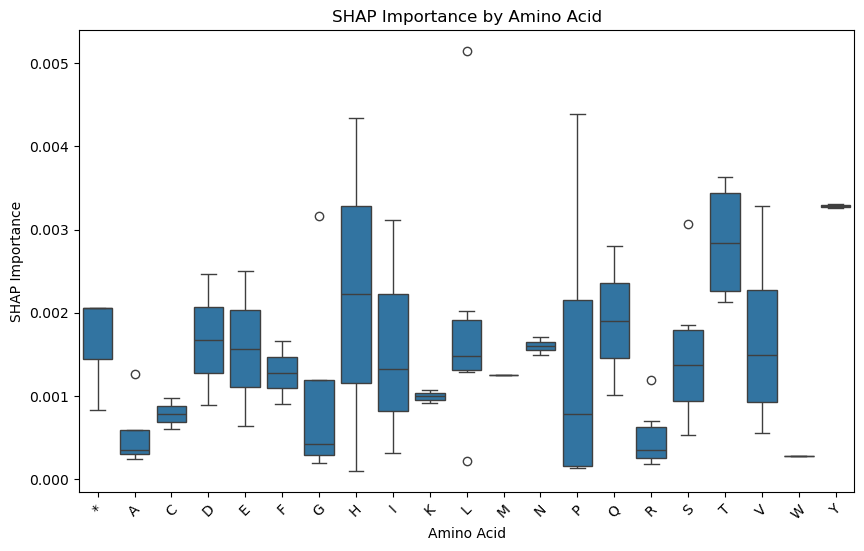

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of SHAP Importance grouped by Amino Acid
plt.figure(figsize=(10, 6))
sns.boxplot(data=dna_rna_amino_acid_df, x='Amino Acid', y='SHAP Importance', order=amino_acid_shap.index)
plt.title('SHAP Importance by Amino Acid')
plt.xlabel('Amino Acid')
plt.ylabel('SHAP Importance')
plt.xticks(rotation=45)
plt.show()


In [110]:
# Known regeneration-related amino acids
regeneration_amino_acids = ['L', 'S', 'P', 'R', 'G']

# Filter for regeneration-related amino acids
regeneration_related = amino_acid_analysis.loc[amino_acid_analysis.index.isin(regeneration_amino_acids)]

regeneration_related


,Count,Total SHAP Importance
Amino Acid,,
L,6,0.011619
S,6,0.009070
P,4,0.006093
G,4,0.004202
R,6,0.003010


In [111]:
# Separate regeneration-related and other amino acids
regen_shap = amino_acid_analysis.loc[regeneration_amino_acids, 'Total SHAP Importance']
other_shap = amino_acid_analysis.loc[~amino_acid_analysis.index.isin(regeneration_amino_acids), 'Total SHAP Importance']

# Perform t-test
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(regen_shap, other_shap, equal_var=False)

print(f"T-test for Regeneration vs Other Amino Acids: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")


T-test for Regeneration vs Other Amino Acids: t-statistic = 1.689, p-value = 0.146


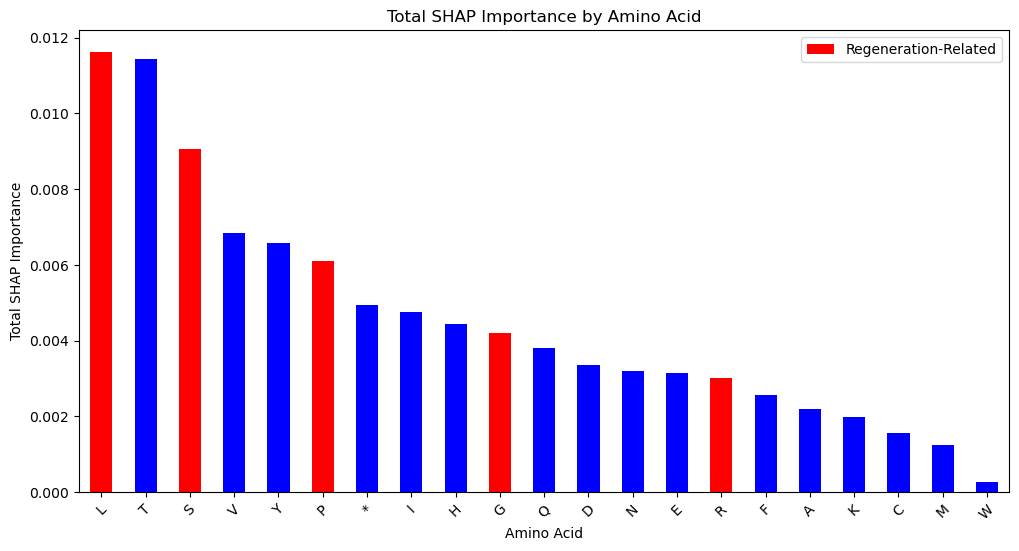

In [112]:
import matplotlib.pyplot as plt

# Highlight regeneration-related amino acids
colors = ['red' if aa in regeneration_amino_acids else 'blue' for aa in amino_acid_analysis.index]

# Bar plot of Total SHAP Importance
plt.figure(figsize=(12, 6))
amino_acid_analysis['Total SHAP Importance'].plot(kind='bar', color=colors)
plt.title('Total SHAP Importance by Amino Acid')
plt.xlabel('Amino Acid')
plt.ylabel('Total SHAP Importance')
plt.xticks(rotation=45)
plt.legend(['Regeneration-Related', 'Other'])
plt.show()


In [114]:
# Filter original DataFrame for top amino acids
top_amino_acids = ['L', 'T', 'S']
top_kmers = dna_rna_amino_acid_df[dna_rna_amino_acid_df['Amino Acid'].isin(top_amino_acids)]

# Group by Amino Acid and sort by SHAP Importance
top_kmer_analysis = top_kmers.sort_values(by='SHAP Importance', ascending=False)
top_kmer_analysis


,Feature,SHAP Importance,DNA,RNA,Amino Acid
66,kmer_3_CTA,0.005147,CTA,CUA,L
61,kmer_3_ACA,0.003629,ACA,ACA,T
47,kmer_3_ACT,0.003371,ACT,ACU,T
63,kmer_3_TCG,0.003068,TCG,UCG,S
50,kmer_3_ACC,0.002311,ACC,ACC,T
57,kmer_3_ACG,0.002130,ACG,ACG,T
35,kmer_3_CTC,0.002022,CTC,CUC,L
64,kmer_3_TCC,0.001855,TCC,UCC,S
45,kmer_3_AGT,0.001593,AGT,AGU,S
39,kmer_3_TTA,0.001561,TTA,UUA,L


In [ ]:
def parse_fasta_file(file_path):
    """Parses a FASTA file and extracts the sequences."""
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
    return sequences

def extract_features_from_sequences(sequences, k=3):
    """Extracts features from a list of sequences."""
    features = []
    for seq in sequences:
        if len(seq) < k:  # Skip sequences too short for k-mer analysis
            continue
        feature_row = {
            "sequence_length": len(seq),
            "gc_content": compute_gc_content(seq),
            "at_gc_ratio": compute_at_gc_ratio(seq),
        }
        feature_row.update(compute_kmer_frequencies(seq, k=k))
        features.append(feature_row)
    return pd.DataFrame(features)

# Step 4: Scale the Features
def scale_features(data_df, scaler):
    """Scales the features using the provided scaler."""
    # Reindex to ensure alignment with scaler features
    data_df = data_df.reindex(columns=scaler.feature_names_in_, fill_value=0)
    return scaler.transform(data_df)

# Step 5: Make Predictions
def predict_and_save_results(model, scaler, data_df, output_file, threshold=0.5):
    """Predicts classes using the model and saves results to a CSV file."""
    # Scale features
    scaled_data = scale_features(data_df, scaler)
    
    # Predict probabilities
    predictions = model.predict(scaled_data)
    
    # Convert probabilities to binary classes
    predicted_classes = (predictions > threshold).astype(int)
    
    # Add predictions to DataFrame
    data_df['predicted_class'] = predicted_classes
    data_df['predicted_probability'] = predictions
    
    # Save to CSV
    data_df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

# Step 6: Main Workflow
def main(fasta_file, scaler, model, output_file, k=3):
    # Parse sequences from FASTA
    sequences = parse_fasta_file(fasta_file)
    
    # Extract features
    new_data_df = extract_features_from_sequences(sequences, k=k)
    
    # Predict and save results
    predict_and_save_results(model, scaler, new_data_df, output_file)

# Run the pipeline
if __name__ == "__main__":
    fasta_file = "axolotl_cds_from_genomic.fna"  # Replace with your FASTA file path
    output_file = "cds_predictions.csv"
    
    # Use your trained scaler and model here
    # Assuming scaler and model are preloaded
    main(fasta_file, scaler, model, output_file, k=3)


1613/1613 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
Predictions saved to cds_predictions.csv


In [ ]:
# Load the predictions file
predictions_df = pd.read_csv("cds_predictions.csv")

# Inspect the first few rows
print(predictions_df.head())

# Summary of the file
print(predictions_df.info())


   sequence_length  gc_content  at_gc_ratio  kmer_3_ATG  kmer_3_TGC  \
0             1122    0.488414     1.047445    0.025000    0.024107   
1             1041    0.537944     0.858929    0.018287    0.018287   
2             1242    0.505636     0.977707    0.016935    0.022581   
3             1149    0.499565     1.001742    0.016565    0.020052   
4              777    0.518662     0.928040    0.015484    0.020645   

   kmer_3_GCC  kmer_3_CCA  kmer_3_CAA  kmer_3_AAA  kmer_3_AAG  ...  \
0    0.015179    0.023214    0.024107    0.019643    0.016964  ...   
1    0.013474    0.022137    0.013474    0.014437    0.015399  ...   
2    0.013710    0.019355    0.024194    0.018548    0.013710  ...   
3    0.011334    0.020052    0.025283    0.019180    0.013949  ...   
4    0.015484    0.021935    0.024516    0.016774    0.016774  ...   

   kmer_3_GAA  kmer_3_GCG  kmer_3_CGG  kmer_3_ACG  kmer_3_ATC  kmer_3_CGA  \
0    0.013393    0.007143    0.006250    0.007143    0.013393    0.008036  

In [19]:
# Summary statistics for numerical features
print(predictions_df.describe())

# Class distribution
print(predictions_df['predicted_class'].value_counts())


       sequence_length    gc_content   at_gc_ratio    kmer_3_ATG  \
count     51594.000000  51594.000000  51594.000000  51585.000000   
mean       2118.118890      0.495574      1.040337      0.021023   
std        2244.125994      0.052416      0.214895      0.006074   
min          96.000000      0.255952      0.278997      0.000235   
25%         960.000000      0.457953      0.886689      0.017576   
50%        1488.000000      0.493168      1.027707      0.020781   
75%        2487.000000      0.530029      1.183631      0.024181   
max      101004.000000      0.781863      2.906977      0.131767   

         kmer_3_TGC    kmer_3_GCC    kmer_3_CCA    kmer_3_CAA    kmer_3_AAA  \
count  51533.000000  51396.000000  51496.000000  51530.000000  51368.000000   
mean       0.019462      0.016213      0.022224      0.022220      0.025137   
std        0.006394      0.007438      0.007283      0.006715      0.013898   
min        0.000200      0.000240      0.000162      0.000148      0.00

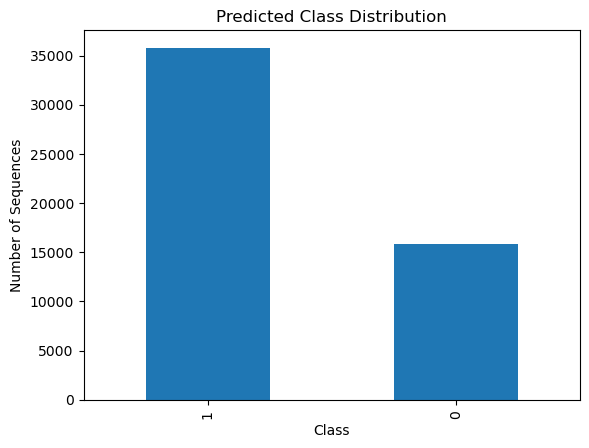

In [20]:
import matplotlib.pyplot as plt

# Plot class distribution
predictions_df['predicted_class'].value_counts().plot(kind='bar')
plt.title("Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Sequences")
plt.show()


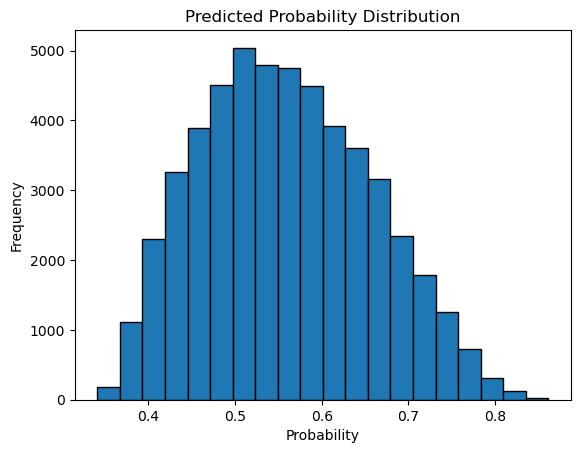

In [ ]:
# Plot probability distribution
plt.hist(predictions_df['predicted_probability'], bins=20, edgecolor='k')
plt.title("Predicted Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

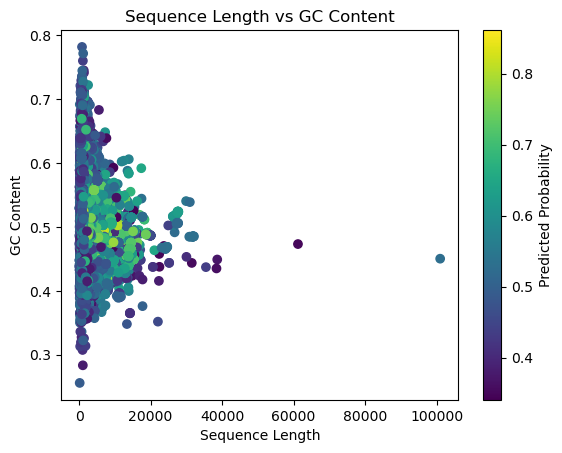

In [17]:
# Scatter plot of sequence length vs GC content, colored by predicted probability
plt.scatter(predictions_df['sequence_length'], predictions_df['gc_content'], 
            c=predictions_df['predicted_probability'], cmap='viridis')
plt.colorbar(label='Predicted Probability')
plt.title("Sequence Length vs GC Content")
plt.xlabel("Sequence Length")
plt.ylabel("GC Content")
plt.show()


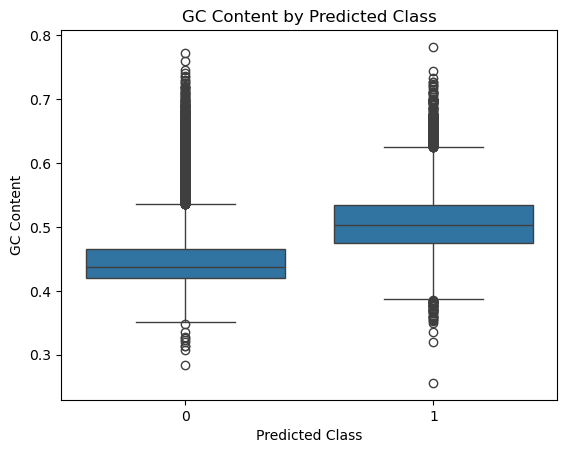

In [20]:
import seaborn as sns

# Box plot for GC content by predicted class
sns.boxplot(x='predicted_class', y='gc_content', data=predictions_df)
plt.title("GC Content by Predicted Class")
plt.xlabel("Predicted Class")
plt.ylabel("GC Content")
plt.show()
